In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
library(brms)
library(haven) # to load the SPSS .sav file
library(tidyverse) # needed for data manipulation.
library(RColorBrewer) # needed for some extra colours in one of the graphs
library(ggmcmc)
library(ggthemes)
library(ggridges)

# IMPORT VISUALIZATION LIBRARIES:
library(data.table)
library(ggplot2)
library(ggridges)
library(dplyr)
library(tidyr)
library(scales)
library(viridis)

In [4]:
df <- read.table('uncon_v_con_shock_MR_ROI24final_with_covariates.txt',header = TRUE,sep = "\t")
head(df)

,Subj,ROI,Y,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff_stdz
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,L Amygdala (BLBM),-0.0841,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
2,P00,R Amygdala (BLBM),0.1305,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
3,P00,L Amygdala (CeME),0.1827,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
4,P00,R Amygdala (CeME),0.2318,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
5,P00,L aMCC,1.3089,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
6,P00,R aMCC,0.8594,-1.003,-0.0406,-1.2307,-0.1812,-0.8664


# **1. BML**

## **Model**
ROIs will have varying intercepts and varying slopes for every independent variable.

<center>Y $\sim$ 1 + TM + TD + SM + SD + BPD + (1 | SUB) + (1 + TM + TD + SM + SD + BPD | ROI) </center>

$$Y \sim Student\_t(\nu,\mu_{s,r},\sigma^{2}_{\epsilon})$$  
$$\mu_{s,r} = \alpha + \alpha_{SUB} + \alpha_{ROI} + (\beta_{TM}+\beta_{ROI_{TM}})*TM + (\beta_{TD}+\beta_{ROI_{TD}})*TD + (\beta_{SM}+\beta_{ROI_{SM}})*SM + (\beta_{SD}+\beta_{ROI_{SD}})*SD + (\beta_{BPD}+\beta_{ROI_{BPD}})*BPD + \epsilon$$

## **Priors**
$\alpha \sim Student\_t(3,0,10)$ [population effect]  
$\alpha_{SUB} \sim Student\_t(\nu_{SUB},0,\sigma_{SUB})$ [Subject effect]  
$\alpha_{ROI} \sim Student\_t(\nu_{ROI},0,\sigma_{ROI})$ [ROI effect]  

$\beta_{TM} \sim Student\_t(3,0,10)$ [population effect: TM]  
$\beta_{TD} \sim Student\_t(3,0,10)$ [population effect: TD]  
$\beta_{SM} \sim Student\_t(3,0,10)$ [population effect: SM]  
$\beta_{SD} \sim Student\_t(3,0,10)$ [population effect: SD]  
$\beta_{BPD} \sim Student\_t(3,0,10)$ [population effect: BPD]  

$\begin{bmatrix}
  \alpha_{ROI} \\
  \beta_{ROI_{TM}} \\
  \beta_{ROI_{TD}} \\
  \beta_{ROI_{SM}} \\
  \beta_{ROI_{SD}} \\
  \beta_{ROI_{BPD}}
\end{bmatrix} \sim MVNormal(\begin{bmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0\end{bmatrix},S)$

$ S = \begin{bmatrix} \sigma_{\alpha_{ROI}} & & & & & \\ & \sigma_{\beta_{ROI_{TM}}} & & & & \\ & & \sigma_{\beta_{ROI_{TD}}} & & & \\ & & & \sigma_{\beta_{ROI_{SM}}} & & \\ & & & & \sigma_{\beta_{ROI_{SD}}} & \\ & & & & & \sigma_{\beta_{ROI_{BPD}}} \end{bmatrix} R \begin{bmatrix} \sigma_{\alpha_{ROI}} & & & & & \\ & \sigma_{\beta_{ROI_{TM}}} & & & & \\ & & \sigma_{\beta_{ROI_{TD}}} & & & \\ & & & \sigma_{\beta_{ROI_{SM}}} & & \\ & & & & \sigma_{\beta_{ROI_{SD}}} & \\ & & & & & \sigma_{\beta_{ROI_{BPD}}} \end{bmatrix}$



$\sigma_{SUB} \sim HalfStudent(3,0,10)$ [prior stddev for Subject effect]  
$\sigma_{ROI} \sim HalfStudent\_t(3,0,10)$ [prior stddev for ROI effect]  
$\nu_{SUB} \sim \Gamma(3.325,0.1)$ [Subject effect hyperprior]  
$\nu_{ROI} \sim \Gamma(3.325,0.1)$ [ROI effect hyperprior]  

$\sigma_{\alpha} \sim HalfStudent(3,0,10)$ [prior stddev among intercepts]  
$\sigma_{\beta} \sim HalfStudent(3,0,10)$ [prior stddev among intercepts]  

$R \sim LKJcorr(1)$ [prior of correlation]  

$\nu \sim \Gamma(3.325,0.1)$ [hyperprior for $\nu$ of liklihood]  
$\sigma_{\epsilon} \sim Student\_t(3,0,10)$ [prior for residual std]

Where,  
TM: Trait mean  
TD: Triat difference  
SM: State mean  
SD: State difference  
BPD: button press difference  


In [5]:
mod = '1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + BPdiff_stdz'
modelForm = paste('Y ~',mod,'+ (1 | gr(Subj, dist= "student")) + (',mod,'| gr(ROI, dist="student"))')
priorRBA <- get_prior(formula = modelForm,data=df,family = 'student')
priorRBA$prior[2:6] <- "student_t(3,0,10)"
priorRBA$prior[9:10] <- "gamma(3.325,0.1)"
priorRBA$prior[12] <- "gamma(3.325,0.1)"
priorRBA

,prior,class,coef,group,resp,dpar,nlpar,bound
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,b,,,,,,
2,"student_t(3,0,10)",b,BPdiff_stdz,,,,,
3,"student_t(3,0,10)",b,STATEdiff,,,,,
4,"student_t(3,0,10)",b,STATEmean,,,,,
5,"student_t(3,0,10)",b,TRAITdiff,,,,,
6,"student_t(3,0,10)",b,TRAITmean,,,,,
7,lkj(1),cor,,,,,,
8,,cor,,ROI,,,,
9,"gamma(3.325,0.1)",df,,ROI,,,,


In [6]:
iterations <- 10000
chains <- 4
SCALE <- 1
ns <- iterations*chains/2


qVars = 'STATEmean,TRAITmean,STATEdiff,TRAITdiff,BPdiff_stdz'
EOI = 'Intercept,STATEmean,TRAITmean,STATEdiff,TRAITdiff,BPdiff_stdz'
EOIq <- strsplit(qVars, '\\,')[[1]]
if(!('Intercept' %in% EOIq)) EOIq <- c('Intercept', EOIq)
EOIq <- intersect(strsplit(EOI, '\\,')[[1]], EOIq)
EOIq


dataTable <- df

# number of ROIs
nR <- nlevels(dataTable$ROI)

# number of sigfigs to show on the table
nfigs <- 4

head(dataTable)

[1] "Intercept"   "STATEmean"   "TRAITmean"   "STATEdiff"   "TRAITdiff"  
[6] "BPdiff_stdz"

,Subj,ROI,Y,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff_stdz
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,L Amygdala (BLBM),-0.0841,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
2,P00,R Amygdala (BLBM),0.1305,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
3,P00,L Amygdala (CeME),0.1827,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
4,P00,R Amygdala (CeME),0.2318,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
5,P00,L aMCC,1.3089,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
6,P00,R aMCC,0.8594,-1.003,-0.0406,-1.2307,-0.1812,-0.8664


In [7]:
fm <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          prior = priorRBA,
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL 'd956566839e0c186dd6f90e1bdca9876' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 982.99 seconds (Warm-up)
Chain 1:                972.13 seconds (Sampling)


Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”


In [8]:
cat(capture.output(summary(fm)),sep = '\n', append=TRUE)

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: Y ~ 1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + BPdiff_stdz + (1 | gr(Subj, dist = "student")) + (1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + BPdiff_stdz | gr(ROI, dist = "student")) 
   Data: dataTable (Number of observations: 1464) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~ROI (Number of levels: 24) 
                           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
df                            30.72     18.03     6.49    75.37 1.00      830
sd(Intercept)                  0.05      0.01     0.03     0.08 1.00     7459
sd(STATEmean)                  0.02      0.01     0.00     0.04 1.00     6749
sd(TRAITmean)                  0.01      0.01     0.00     0.03 1.00    11109
sd(STATEdiff)                  0.03      0.01     0.01     0.06 1.00     6704
sd(TRAITdiff)                  0.0

In [9]:
# Extract posteriors for fixed (aa) and random effects (bb)
aa <- fixef(fm, summary = FALSE)/SCALE # Population-Level Estimates
bb <- lapply(ranef(fm, summary = FALSE), `/`, SCALE) # Extract Group-Level (or random-effect)

### Functions

In [10]:
# Following functions add the "the poaterior of the global intercept with the intercept posterior of each roi"
# bb[['ROI']][,,tm] is a matrix with columns containing posteriors for every ROI
# aa[,tm] is a single column posterior for the global intercept.
psROI <- function(aa, bb, tm) {
  ps <- apply(bb[['ROI']][,,tm], 2, '+', aa[,tm])
  return(ps)
}
# apply(X,axis,func,..)
# check help for apply (?apply)


# compute P+
cnt <- function(x, ns) return(sum(x>0)/ns)
# summary for ROIs: nd - number of digits to output
sumROI <- function(R0, ns, nd) {
  hubs <- data.frame(cbind(apply(R0, 2, mean), apply(R0, 2, sd), apply(R0, 2, cnt, ns), t(apply(R0, 2, quantile, 
      probs=c(0.025, 0.05, 0.5, 0.95, 0.975)))))
  names(hubs) <- c('mean', 'SD', 'P+', '2.5%', '5%', '50%', '95%', '97.5%')
  return(round(hubs,nd))
}

################################# conventional GLM ############################################
sumGLM <- function(ll, tm, nR, DF, nd) {
   th <- qt(c(0.025, 0.05, 0.5, 0.95, 0.975), DF)
   rr <- matrix(0, nrow = nR, ncol = 8, dimnames=list(levels(dataTable$ROI), c('mean', 'SD', '2-sided-p', '2.5%', '5%', '50%', '95%', '97.5%')))
   rownames(rr) <- levels(dataTable$ROI)
   if(tm == 'Intercept') tm <- '(Intercept)'
   for(ii in 1:nR) {
     u1 <- ll[[ii]]$coefficients[tm,1] # mean
     u2 <- ll[[ii]]$coefficients[tm,2] # sd
     u3 <- ll[[ii]]$coefficients[tm,4] # 2-sided p
     rr[ii,] <- round(c(u1, u2, u3, u1+u2*th),nd)
   } 
   return(rr)
}

################################# function to plot posteriors ##################################
plotPDP <- function(ps0,gg_brm,gg_glm){
rois <- colnames(ps0) # Global intercept + ROI intercepts
nobs=dim(ps0)[1] # gets number of rows and assigns it to nobj

# initialize a single column dataframe with number of row equal to number of rois
data_stats = data.frame(1:length(rois)) 
data_stats$ROI <- rois # adds an ROI column with roi names

#data_stats$mean <- colMeans(data)
data_stats$brmMean <- gg_brm$mean # Adds a brmMean columns
data_stats$glmMean <- gg_glm$mean # Adds a brmMean columns

# gets proportion of the posterior greater than 0 for each roi
data_stats$P <- colSums(ps0 > 0)/nobs 
# gets proportion of the posterior less than 0
#data_stats$Pn <- 1 - data_stats$P
data_stats$Pn <- data_stats$P
for (i in 1:length(rois)) {
  if (data_stats$P[i]<.5){data_stats$Pn[i]=1-data_stats$P[i]}
}

# this will order the distributions correctly
#data_stats <- data_stats[order(data_stats$brmMean),]
data_stats <- data_stats[order(data_stats$P),]

data_trans <- as.data.frame(t(as.matrix(ps0)))
data_trans <- tibble::rownames_to_column(data_trans, "ROI")
data_trans$X <- 1:nrow(data_trans)

# merge values & stats into one table by ROI
data_merge <- merge(data_stats, data_trans, by = "ROI")
data_merge <- data_merge[order(data_merge$X),]

# Transform data into long form
# Melt dataframe by ROI
library(data.table)

data_long <- melt(data_trans, id=c("ROI","X"))
data_long <- data_long[order(data_long$X),]

# This is incredibly clunky, but for the sake of time adding stats by ensuring orders are all the same and repeating each value 2000 times... Tried a few different methods with no success for some reason. 

data_long$brmMean <- rep(data_merge$brmMean, each = nobs)
data_long$glmMean <- rep(data_merge$glmMean, each = nobs)
data_long$P <- rep(data_merge$P, each =nobs)
data_long$Pn <- rep(data_merge$Pn, each =nobs)

# set your labels here so you don't have to change within the plot below: 
format(round(1, 2), nsmall = 2)

y.axis.labs <- format(round(data_stats$P,3), nsmall = 2)                        # y axis labels
sec.y.axis.labs <- data_stats$ROI                             # second y axis labels (probabilities)

 # X AXIS LABELS NEED TO CHANGE TO CORRESPOND TO DATA SET! UNCOMMENT WHICHEVER MATCHES

# Uncomment for THREAT
x.axis.labs <- c( "control > uncontrol", "0", "uncontrol > control")                 # x axis labels  THREAT
x.labs.pos <- c(-0.2, 0, 0.2)                                             # x axis position THREAT

#graph.title <- data.name                                   # graph title 
legend.title <- "Probability"                              # legend title
y.axis.title <- NULL                                       # for now ...
x.axis.title <- NULL                                       # for now...

# GRAPH DATA
library(repr)
options(repr.plot.width=10,repr.plot.height=8)

dataset <- data_long
x.values <- data_long$value                               # x values
y.values <- data_long$ROI                                 # y values
y.values.RO <- data_long$value                            # values to reorder Y by
distrib.fill <- data_long$Pn                              # fill graph with probabilities
group <- data_long$ROI

# Other aspects
gradient.colors <- c("yellow","#C9182B","#41245C")        # change gradient colors here (currently, yellow - purple)
label.size <- 16                                         # adjust ROI and probability y-axis font size
title.size <- 32                                         # adjust graph title size 
x.axis.size <- 16                                        # adjust x-axis label sizes

# here is where you can change information about the graph and add other characteristics using ggplot and ggridges


ggplot(dataset, aes(x = x.values, y = as.numeric(reorder(y.values, y.values.RO)), 
                    fill = distrib.fill, group = group)) +                      # scale = spacing, alpha = transparency
  coord_cartesian(xlim = c(-0.25, 0.25)) +
  stat_density_ridges(quantile_lines = TRUE, 
                      quantiles = 2, 
                      alpha = .95, 
                      scale = 1,
                      color = "black",
                      size = .35
                     ) +
    geom_segment(aes(x = glmMean, xend = glmMean, y = as.numeric(reorder(y.values, y.values.RO)),
                                      yend = as.numeric(reorder(y.values, y.values.RO))+0.9), color = "red") +           # divide into two quantiles (show mean)
  geom_vline(xintercept = 0, linetype="solid",color = "black",alpha = .95, size = .45) +    #create line at X = 0
  scale_fill_gradientn(colors = viridis_pal(direction = 1, option = "inferno")(20),                         # set gradient
                       limits = c(.85,1),                                # which probabilites matter?
                       na.value = "#909497",                                # if not in limits, gray out
                       name = legend.title) +                            # name legend
  scale_y_continuous(breaks = 1:length(rois),                            # A VERY HACK-Y WAY TO HAVE TWO Y AXES W DISCRETE DATA
                     expand = c(0,0),
                     labels = y.axis.labs,                               # Trick ggplot into thinking data is continuous...
                     sec.axis = sec_axis(~.,                             # Second axis to show probabilities
                                         breaks = 1:length(rois),
                                         labels = sec.y.axis.labs)) +
  #theme_ridges(font_size = label.size, grid = TRUE, center_axis_labels = TRUE) +  # theme info
  #ggtitle(graph.title)+ 
  #theme_bw() +# graph title
 #theme_ridges(grid = FALSE) + 
  theme(   
    panel.background = element_blank(),
    #legend.position = "none",
    #panel.grid.major.y = element_line(color = "grey"), 
    plot.title = element_text(hjust = 0.5, size = title.size),            # plot title size and position
    axis.text.y = element_text(size=label.size),                               # y-axis text size
    axis.line.x = element_line(color = "gray"),
    axis.text.y.right = element_text(size = label.size),                  # y-axis info for right axis
    axis.text.x = element_text(size = x.axis.size),
    #plot.margin = unit(c(0,0,0,0), "cm"),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(),
    legend.title.align = 5)+
  guides(shape = guide_legend(label.position = "bottom",
                              title.positon = "bottom",
                              title.vjust = 0.4)) +          
  labs(
    x = NULL,                                                         # Add or not add X and Y labels
    y = NULL) +
  scale_x_continuous(breaks = x.labs.pos, labels = c(x.axis.labs))
}

# **2. BML and GLM Summaries with Posterior Plots**

===== Summary of region effects for Intercept (RBA results) =====
                                             mean     SD     P+    2.5%      5%
L aMCC                                     0.0189 0.0334 0.7183 -0.0471 -0.0359
L Amygdala (BLBM)                          0.0153 0.0352 0.6697 -0.0540 -0.0429
L Amygdala (CeME)                          0.0484 0.0384 0.9014 -0.0255 -0.0138
L Anterior dorsal insula                   0.0745 0.0337 0.9881  0.0098  0.0199
L Anterior hippocampus                     0.0041 0.0334 0.5555 -0.0628 -0.0515
L Anterior ventral insula (anterior pole)  0.0095 0.0325 0.6168 -0.0557 -0.0439
L BST                                      0.1308 0.0472 0.9988  0.0400  0.0551
L Mid posterior insula                    -0.0011 0.0323 0.4948 -0.0663 -0.0553
L PAG                                      0.0251 0.0341 0.7738 -0.0424 -0.0313
L Thalamus (emoproxI shock intersection)   0.0485 0.0328 0.9320 -0.0157 -0.0049
PCC (1)                                   -0.0219 0.03

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00443



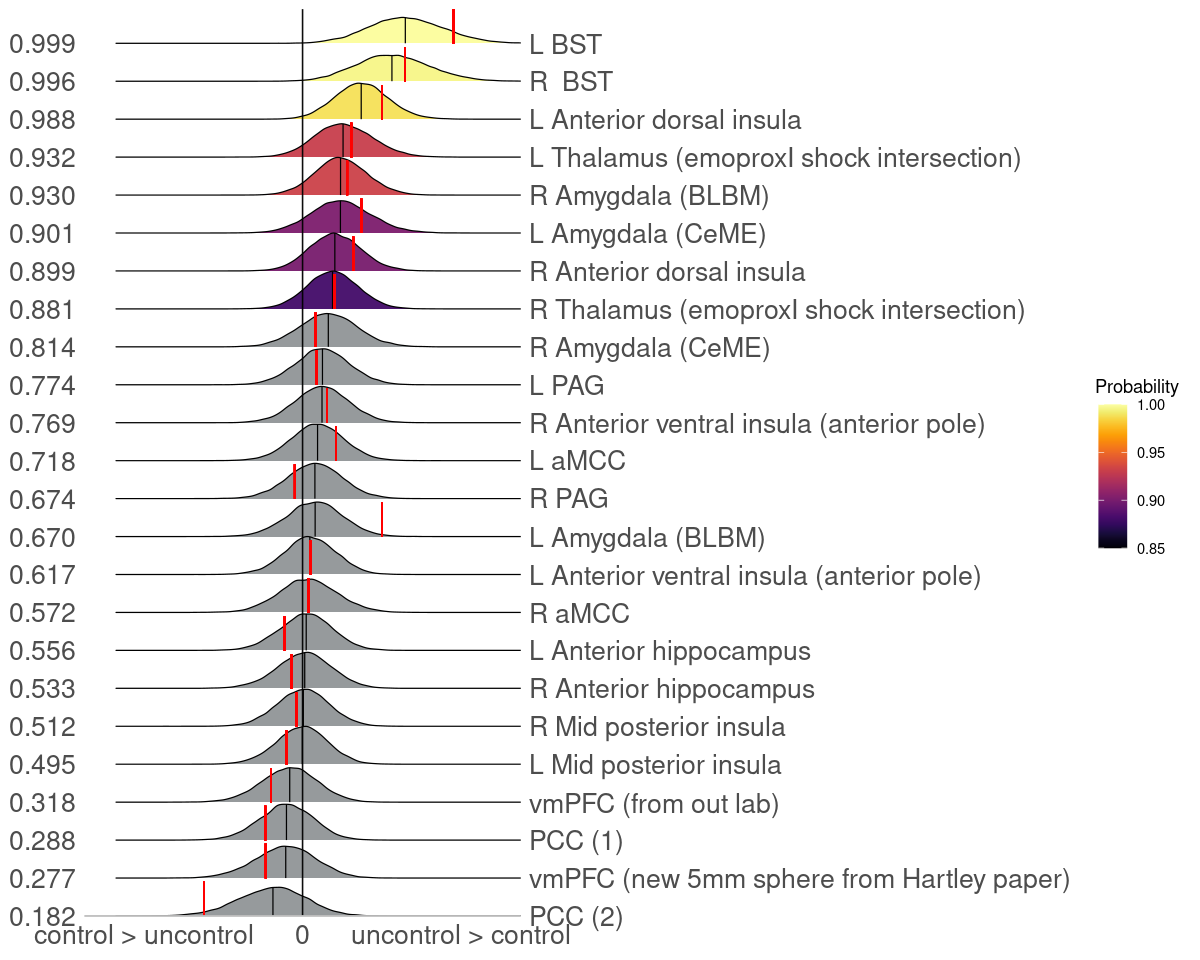

In [11]:
# for Intercept and quantitative variables
ii = 1
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

Red vertical lines: GLM

===== Summary of region effects for BPdiff_stdz (RBA results) =====
                                             mean     SD     P+    2.5%      5%
L aMCC                                     0.0165 0.0344 0.6875 -0.0512 -0.0405
L Amygdala (BLBM)                          0.0366 0.0352 0.8535 -0.0305 -0.0196
L Amygdala (CeME)                          0.0118 0.0366 0.6250 -0.0609 -0.0478
L Anterior dorsal insula                   0.0008 0.0327 0.5122 -0.0634 -0.0534
L Anterior hippocampus                     0.0269 0.0333 0.7934 -0.0385 -0.0273
L Anterior ventral insula (anterior pole) -0.0043 0.0331 0.4549 -0.0708 -0.0595
L BST                                     -0.0548 0.0479 0.1226 -0.1532 -0.1359
L Mid posterior insula                     0.0403 0.0329 0.8922 -0.0231 -0.0128
L PAG                                     -0.0010 0.0340 0.4912 -0.0696 -0.0577
L Thalamus (emoproxI shock intersection)  -0.0030 0.0330 0.4664 -0.0692 -0.0578
PCC (1)                                   -0.0040 0.

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00446



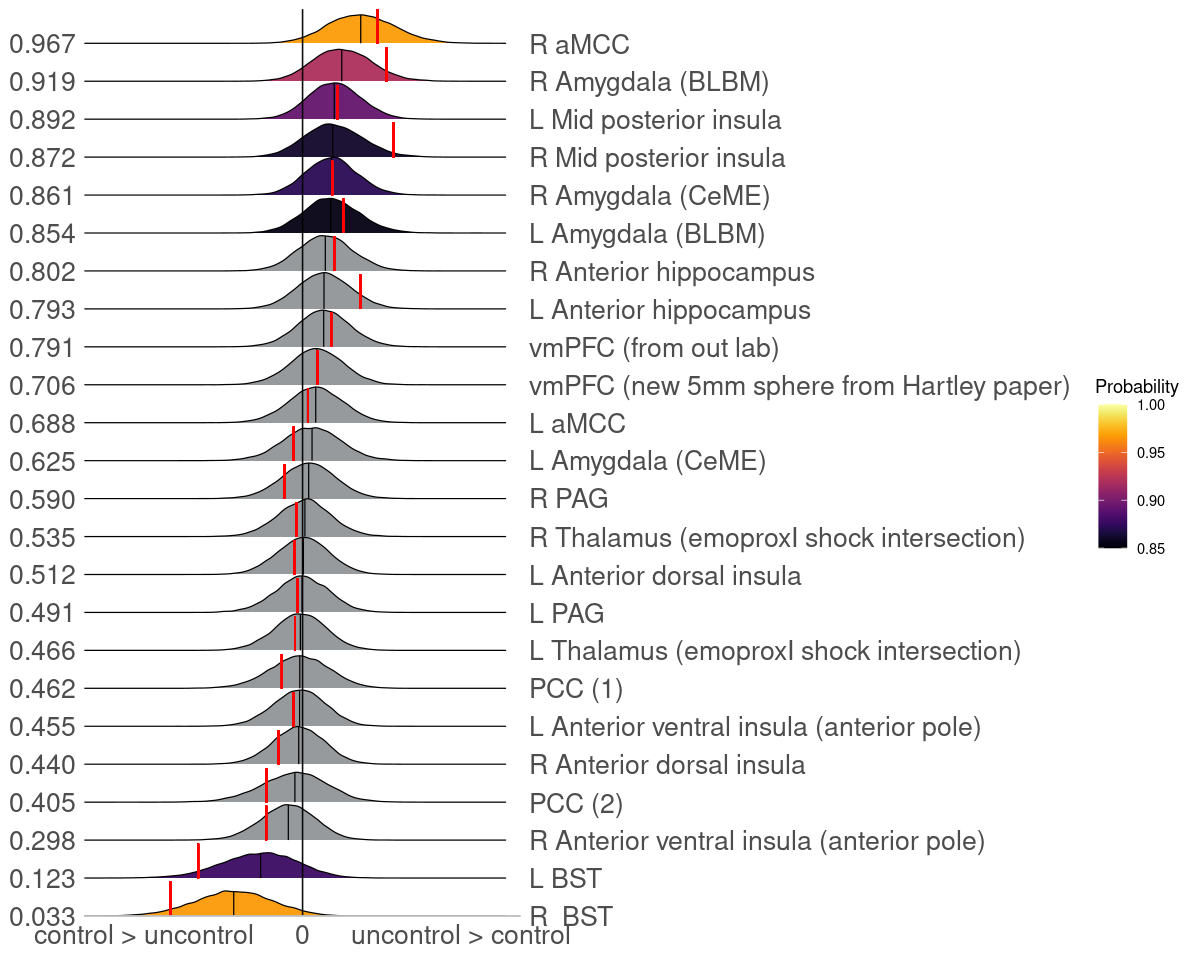

In [12]:
ii = 6
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for STATEmean (RBA results) =====
                                             mean     SD     P+    2.5%      5%
L aMCC                                     0.0088 0.0314 0.6092 -0.0526 -0.0423
L Amygdala (BLBM)                          0.0057 0.0316 0.5721 -0.0568 -0.0458
L Amygdala (CeME)                          0.0109 0.0325 0.6300 -0.0526 -0.0417
L Anterior dorsal insula                   0.0033 0.0321 0.5466 -0.0613 -0.0501
L Anterior hippocampus                     0.0083 0.0315 0.6044 -0.0540 -0.0433
L Anterior ventral insula (anterior pole)  0.0151 0.0316 0.6790 -0.0460 -0.0355
L BST                                      0.0217 0.0365 0.7247 -0.0462 -0.0357
L Mid posterior insula                     0.0028 0.0318 0.5406 -0.0611 -0.0499
L PAG                                      0.0116 0.0314 0.6408 -0.0499 -0.0389
L Thalamus (emoproxI shock intersection)   0.0074 0.0315 0.5941 -0.0547 -0.0444
PCC (1)                                    0.0187 0.03

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00398



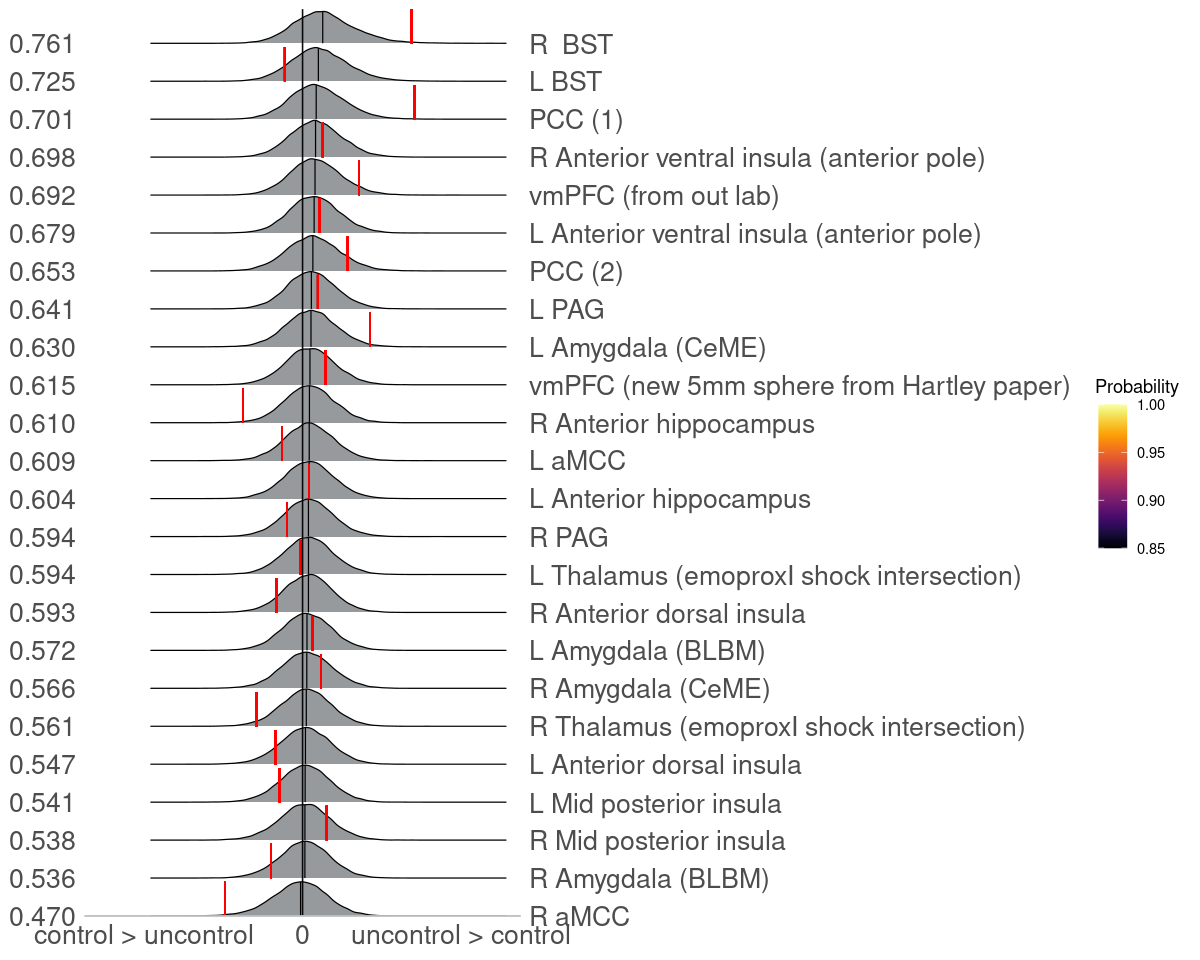

In [13]:
ii = 2
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for TRAITmean (RBA results) =====
                                             mean     SD     P+    2.5%      5%
L aMCC                                    -0.0064 0.0291 0.4072 -0.0631 -0.0534
L Amygdala (BLBM)                         -0.0090 0.0292 0.3756 -0.0670 -0.0569
L Amygdala (CeME)                         -0.0091 0.0295 0.3764 -0.0672 -0.0573
L Anterior dorsal insula                  -0.0095 0.0294 0.3720 -0.0674 -0.0577
L Anterior hippocampus                    -0.0064 0.0292 0.4112 -0.0627 -0.0534
L Anterior ventral insula (anterior pole) -0.0063 0.0293 0.4125 -0.0627 -0.0537
L BST                                     -0.0056 0.0315 0.4216 -0.0664 -0.0561
L Mid posterior insula                    -0.0060 0.0292 0.4146 -0.0624 -0.0534
L PAG                                     -0.0084 0.0291 0.3846 -0.0656 -0.0561
L Thalamus (emoproxI shock intersection)  -0.0102 0.0293 0.3627 -0.0680 -0.0581
PCC (1)                                   -0.0130 0.03

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00368



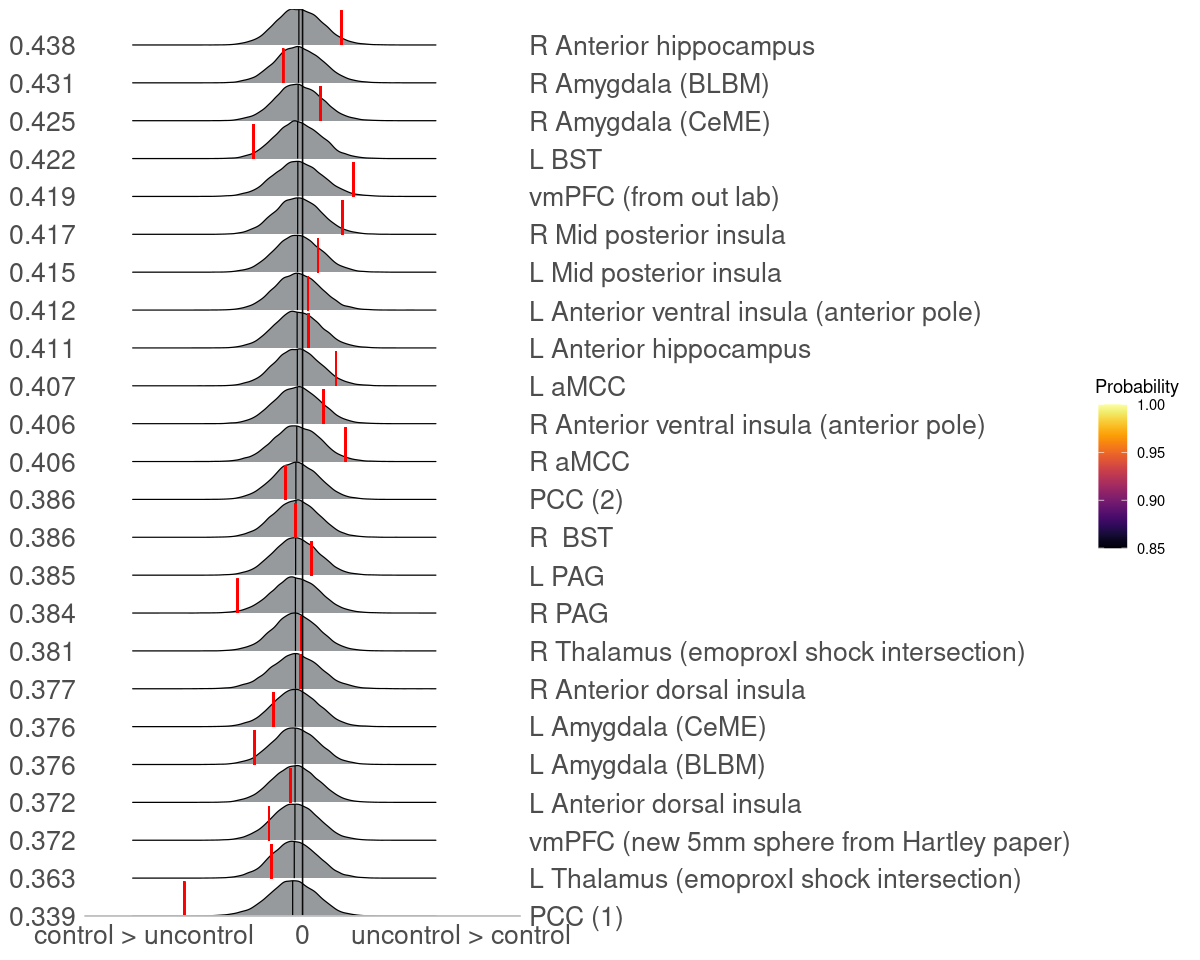

In [14]:
ii = 3
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for STATEdiff (RBA results) =====
                                             mean     SD     P+    2.5%      5%
L aMCC                                     0.0094 0.0316 0.6101 -0.0512 -0.0412
L Amygdala (BLBM)                          0.0015 0.0324 0.5172 -0.0608 -0.0511
L Amygdala (CeME)                          0.0063 0.0344 0.5684 -0.0604 -0.0492
L Anterior dorsal insula                   0.0264 0.0316 0.7978 -0.0339 -0.0245
L Anterior hippocampus                    -0.0011 0.0305 0.4854 -0.0613 -0.0505
L Anterior ventral insula (anterior pole) -0.0296 0.0318 0.1766 -0.0950 -0.0833
L BST                                      0.0492 0.0407 0.8873 -0.0272 -0.0161
L Mid posterior insula                     0.0036 0.0299 0.5455 -0.0538 -0.0450
L PAG                                      0.0040 0.0311 0.5465 -0.0566 -0.0461
L Thalamus (emoproxI shock intersection)   0.0027 0.0298 0.5311 -0.0553 -0.0461
PCC (1)                                   -0.0513 0.03

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.0041



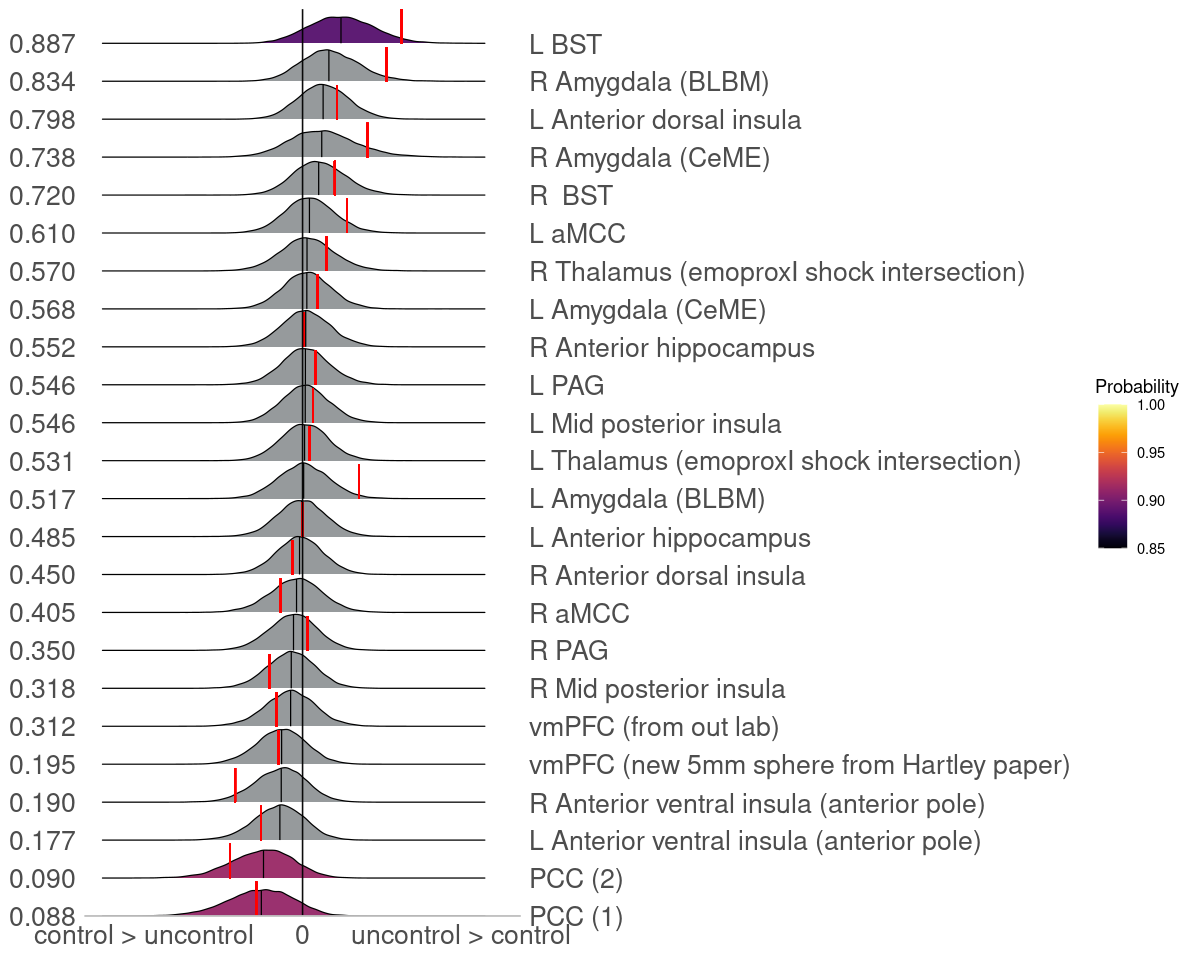

In [15]:
ii = 4
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for TRAITdiff (RBA results) =====
                                             mean     SD     P+    2.5%      5%
L aMCC                                    -0.0048 0.0244 0.4236 -0.0538 -0.0452
L Amygdala (BLBM)                          0.0024 0.0253 0.5275 -0.0456 -0.0379
L Amygdala (CeME)                         -0.0023 0.0249 0.4628 -0.0512 -0.0425
L Anterior dorsal insula                  -0.0008 0.0250 0.4862 -0.0505 -0.0418
L Anterior hippocampus                    -0.0020 0.0244 0.4678 -0.0503 -0.0420
L Anterior ventral insula (anterior pole) -0.0074 0.0250 0.3894 -0.0586 -0.0487
L BST                                      0.0037 0.0280 0.5411 -0.0492 -0.0403
L Mid posterior insula                     0.0012 0.0248 0.5111 -0.0464 -0.0384
L PAG                                     -0.0007 0.0246 0.4849 -0.0482 -0.0401
L Thalamus (emoproxI shock intersection)  -0.0013 0.0245 0.4706 -0.0490 -0.0408
PCC (1)                                   -0.0125 0.02

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00308



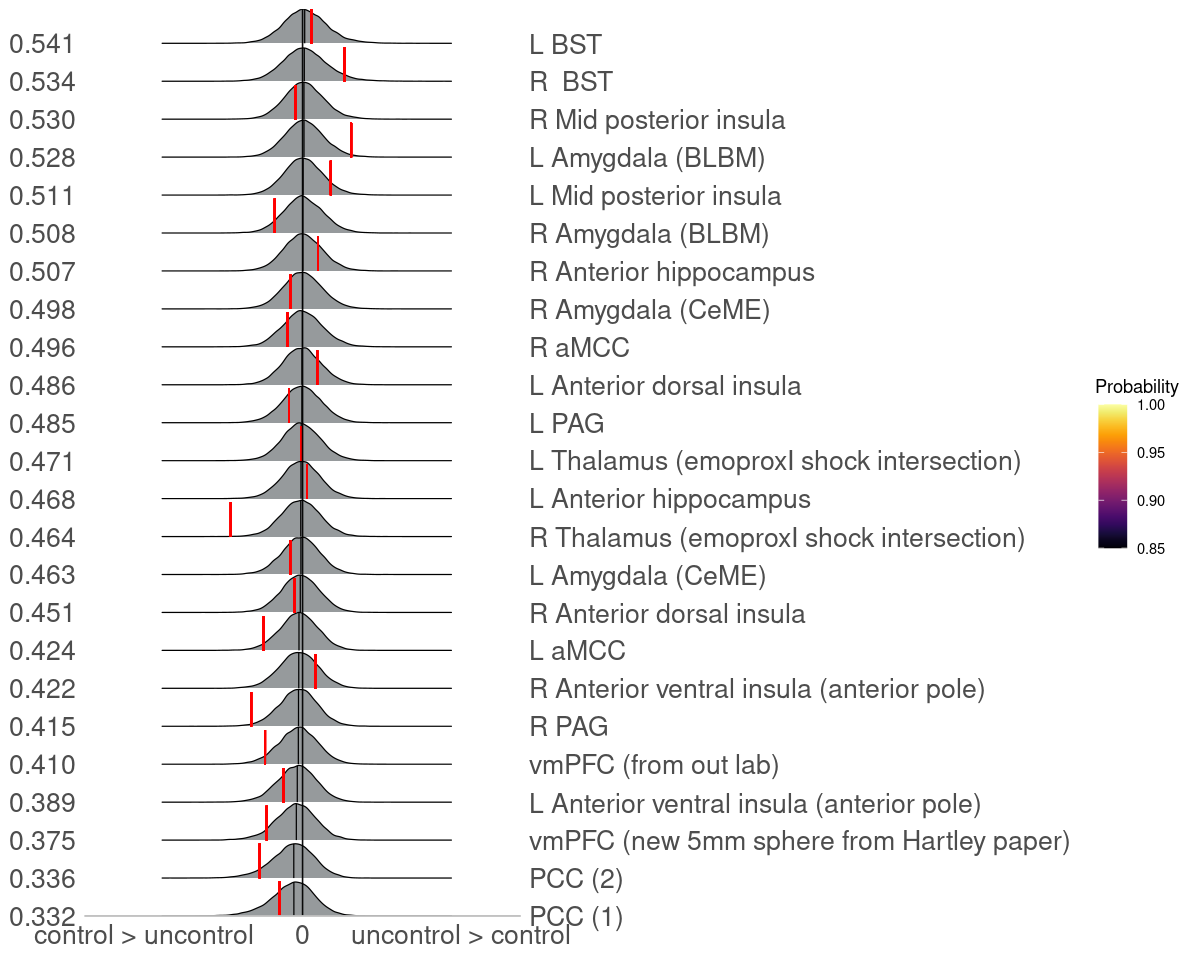

In [16]:
ii = 5
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

# **3. Posterior Predictive Check**

In [17]:
pp_plot = pp_check(fm,nsamples = 100)

Warning message:
“Removed 793 rows containing non-finite values (stat_density).”
Warning message:
“Removed 8 rows containing non-finite values (stat_density).”


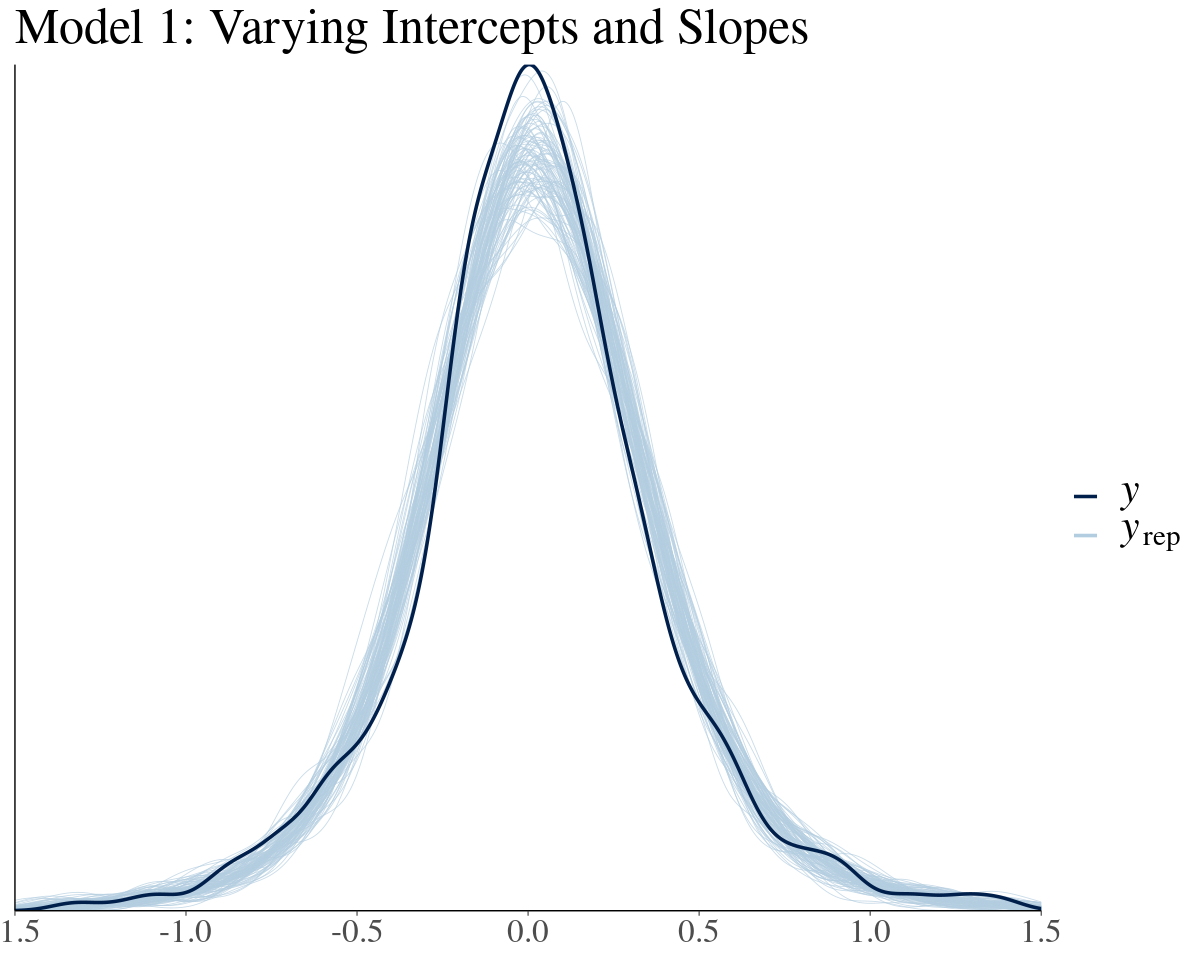

In [18]:
pp_plot + xlim(-1.5,1.5) + theme(text = element_text(size=25),legend.text=element_text(size=25)) + ggtitle("Model 1: Varying Intercepts and Slopes",)

In [24]:
for (eoi in EOIq){
    ps0 <- psROI(aa, bb, eoi)
    write.csv(ps0,paste0('../finalResults/ROI_analysis/uncon_v_con_',eoi,'.txt'))
}